![Colegio Bourbaki](./Images/Bourbaki.png)

## Procesamiento de Lenguaje Natural

### Alocación latente de Dirichlet (Latent Dirichlet Allocation)

La Alocación Latente de Dirichlet (LDA, por sus siglas en inglés) es una técnica poderosa en el campo de aprendizaje automático y procesamiento de lenguaje natural que se utiliza para descubrir los temas subyacentes que están presentes en un conjunto de documentos. Esta técnica resulta especialmente útil en contextos donde los textos son extensos o hay grandes volúmenes de datos textuales, como es el caso de los discursos presidenciales.

En el análisis de discursos presidenciales, LDA puede emplearse para identificar los temas recurrentes a lo largo de los discursos de un periodo de gobierno, o para comparar los enfoques temáticos entre diferentes administraciones o presidentes. Por ejemplo, podría revelar cómo ciertos temas como la economía, la política exterior, o los derechos sociales, se mantienen constantes o varían en importancia según el contexto político y social del momento.

La utilización de LDA en este tipo de análisis permite no solo identificar los temas clave que un presidente aborda a lo largo de su mandato, sino también observar la evolución de estos temas, su relevancia y cómo estos pueden resonar en las políticas implementadas. Por tanto, LDA ofrece una ventana única hacia las prioridades, preocupaciones y estrategias discursivas en el ámbito político, proporcionando un marco para entender mejor la dirección y el enfoque de una presidencia en relación con los temas de interés nacional e internacional.

**En este notebook, nos centraremos en los discursos presidenciales del ex-presidente de Argentina, Alberto Fernández durante el período 2019-2023**

### Librerías

In [1]:
# Procesamiento y Visualizacion de Datos
import pandas as pd

#Plotting
import matplotlib.pyplot as plt

# Preprocesar texto
import glob
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import spacy

# Modelado de tópicos
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

#Utils
from collections import Counter

In [2]:
package = "spacy"

In [3]:
stopwords_gh = pd.read_csv(
        "https://gist.githubusercontent.com/cr0wg4n/78554c5d0afa9944d2fa3a4435d83a57/raw/df59fb916108f2a58bf1a3d8c62818b44231586d/spanish-stop-words.txt",
        header=None,
    )
stopwords_gh = stopwords_gh[0].tolist()
print(f"Stopwords from GitHub: {len(stopwords_gh)}")

if package == 'nltk':
    nltk.download("stopwords")
    stopwords_nltk = stopwords.words("spanish")
    print(f"Stopwords from nltk: {len(stopwords_nltk)}")
    
elif package == 'spacy':
    # !python3 -m spacy download es_core_news_sm
    nlp = spacy.load("es_core_news_sm")
    stopwords_spacy = nlp.Defaults.stop_words
    print(f"Stopwords from spacy: {len(stopwords_spacy)}")
else:
    raise ValueError("Invalid package")

Stopwords from GitHub: 608
Stopwords from spacy: 521


### Funciones de ayuda

In [4]:
def generate_wordcloud(sequence):
    # Crear la cadena con la que haremos la nube de palabras
    text = " ".join(review for review in sequence)

    # Crear la nube de palabras
    wordcloud = WordCloud(
        max_font_size=50,
        max_words=100,
        background_color="white",
        normalize_plurals=False,
        collocations=False,
    ).generate(text)

    # Desplegar la imagen generada
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [5]:
def preprocesar(text, package):
    """
    Preprocesa texto en español usando nltk o spacy según el parámetro `package`.

    :param text: str, texto de entrada
    :param package: str, "nltk" o "spacy"
    :param stopwords_list: lista opcional de stopwords (si no se pasa, usa por defecto)
    :return: str, texto limpio
    """

    # convierte a minúsculas
    text = text.lower()

    # stopwords
    if package == "nltk":
        stopwords_list = stopwords_nltk
    elif package == "spacy" and nlp:
        stopwords_list = stopwords_spacy
    else:
        stopwords_list = stopwords_gh

    # elimina stopwords usando regex
    stop = re.compile(r"\b(" + r"|".join(stopwords_list) + r")\b\s*")
    text = stop.sub("", text)

    # quitar puntuación y números
    text = re.sub("[^ña-záéíóúü]+", " ", text)

    if package == "nltk":
        # Lematizar con WordNet (ojo: WordNet está en inglés, mejor para inglés que español)
        lemma = WordNetLemmatizer()
        text = text.split()
        text = " ".join([lemma.lemmatize(i) for i in text if len(i) > 2])

    elif package == "spacy" and nlp:
        # Procesar con spaCy (mejor para español)
        doc = nlp(text)
        tokens = [
            token.lemma_ for token in doc if len(token.lemma_) > 2 and not token.is_stop
        ]
        text = " ".join(tokens)

    return text

### Carga de datos

Primero leeremos todos los archivos de texto correspondiente a los discursos presidenciales del ex presidente Alberto Fernández.

Si desean hacerlos desde localhost:

In [6]:
speech_list = glob.glob("./Data/AF/*.txt")

df_af = pd.DataFrame(
    columns=["speech", "date", "speech_length"],
    index=[i for i in range(len(speech_list))],
)

In [7]:
date_pattern = re.compile(r"(\d{2})_(\d{2})_(\d{4})")

for key, speech in enumerate(speech_list):
    with open(speech, "r", encoding="utf-8") as file:
        df_af.loc[key, "speech"] = file.read()
    match = date_pattern.search(speech)
    if match:
    # Extract date components from the matched groups
        month = match.group(1)
        day = match.group(2)
        year = match.group(3)
    # Format the date components as MM/DD/YYYY
        formatted_date = f"{month}/{day}/{year}"
    df_af.loc[key, "date"] = formatted_date
    df_af.loc[key, "speech"] = df_af.loc[key, "speech"].replace("(APLAUSOS)", "")
    df_af.loc[key, "speech"] = df_af.loc[key, "speech"].replace("(APLAUSO)", "")
    df_af.loc[key, "speech"] = df_af.loc[key, "speech"].replace("PRESIDENTE FERNANDEZ.-", "")
    df_af.loc[key, "speech"] = df_af.loc[key, "speech"].replace("FERNANDEZ.-", "")
    df_af.loc[key, "speech"] = df_af.loc[key, "speech"].replace("PRESIDENTE.-", "")
    df_af.loc[key, "speech"] = df_af.loc[key, "speech"].replace("PERIODISTA.-", "")
    # df_af["date"][key] = formatted_date
    # df_af["speech"][key] = df_af["speech"][key].replace("(APLAUSOS)", "")
    # df_af["speech"][key] = df_af["speech"][key].replace("(APLAUSO)", "")
    # df_af["speech"][key] = df_af["speech"][key].replace("PRESIDENTE FERNANDEZ.-", "")
    # df_af["speech"][key] = df_af["speech"][key].replace("FERNANDEZ.-", "")
    # df_af["speech"][key] = df_af["speech"][key].replace("PRESIDENTE.-", "")
    # df_af["speech"][key] = df_af["speech"][key].replace("PERIODISTA.-", "")
    df_af.loc[key, "speech_length"] = len(df_af["speech"][key].split())

Pueden hacer web scrapping si así lo desean también. 

In [8]:
df_af

,speech,date,speech_length
0,"Muy bien, muchas gracias querida La Rioja, sie...",06/13/2020,1611
1,Acabamos de tener una extraordinaria reunión c...,01/02/2023,533
2,Señores Jefes de las Fuerzas del Comando Antár...,01/03/2020,588
3,Buenas tardes a todos y a todas; muchas gracia...,01/03/2022,1051
4,"Muy bien, buenas tardes a todos y todas. Graci...",01/03/2023,1290
...,...,...,...
660,"Buen día a todos y a todas, gracias por estar ...",12/28/2020,1908
661,Muchas gracias.\n\nBuenas tardes a todos y a t...,12/29/2021,596
662,"Tener hoy 31 empresas pujantes (INAUDIBLE), a ...",12/29/2022,172
663,Hace dos años lográbamos convertir en ley la L...,12/29/2022,256


In [9]:
# Dtypes assignment
df_af["speech"] = df_af["speech"].astype(str)
df_af["date"] = pd.to_datetime(df_af["date"], errors='coerce') 
df_af["speech_length"] = df_af["speech_length"].astype(int)

In [10]:
df_af

,speech,date,speech_length
0,"Muy bien, muchas gracias querida La Rioja, sie...",2020-06-13,1611
1,Acabamos de tener una extraordinaria reunión c...,2023-01-02,533
2,Señores Jefes de las Fuerzas del Comando Antár...,2020-01-03,588
3,Buenas tardes a todos y a todas; muchas gracia...,2022-01-03,1051
4,"Muy bien, buenas tardes a todos y todas. Graci...",2023-01-03,1290
...,...,...,...
660,"Buen día a todos y a todas, gracias por estar ...",2020-12-28,1908
661,Muchas gracias.\n\nBuenas tardes a todos y a t...,2021-12-29,596
662,"Tener hoy 31 empresas pujantes (INAUDIBLE), a ...",2022-12-29,172
663,Hace dos años lográbamos convertir en ley la L...,2022-12-29,256


In [11]:
# Sorting by date
df_af = df_af.sort_values("date")

In [12]:
df_af

,speech,date,speech_length
625,Señora Vicepresidente; Diputadas; Diputados; S...,2019-12-10,7411
564,"Buenas noches, Argentina. Qué linda es esta no...",2019-12-11,1174
644,"Bueno, buenos días, buenas tardes, buen mediod...",2019-12-18,2223
565,"Parece que hay otro protocolo, pero voy a romp...",2019-12-20,1696
664,Muchas gracias a todos y a todas. Voy a empeza...,2019-12-30,1233
...,...,...,...
557,"Bueno, antes que nada, buenos días: bienvenido...",2023-10-06,127
519,Señor presidente de la República Popular China...,2023-10-18,1079
562,"Buen día a todos y todas, gracias por estar a...",2023-11-19,159
620,"Señor presidente; querido amigo “Lucho”, mi qu...",2023-12-07,514


In [13]:
speechs = " ".join(df_af["speech"][i] for i in range(len(df_af)))

print(f"Total words in speech: {len(speechs.split())}")
words_speechs = Counter(speechs.split())
words_speechs.most_common(10)

Total words in speech: 1079651


[('que', 60181),
 ('de', 49490),
 ('la', 36868),
 ('y', 32693),
 ('a', 27208),
 ('en', 26024),
 ('el', 24652),
 ('los', 15906),
 ('es', 14020),
 ('un', 13184)]

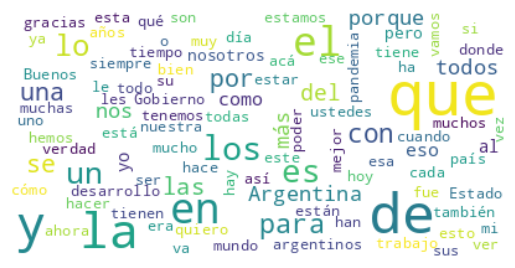

In [14]:
generate_wordcloud(df_af["speech"])

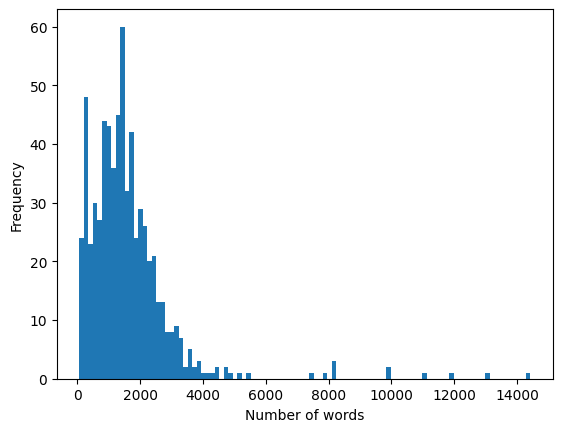

In [15]:
df_af["speech_length"].plot.hist(bins=100)
plt.xlabel("Number of words")
plt.show()

In [16]:
df_af["speech_length"].describe()

count      665.000000
mean      1623.535338
std       1446.114435
min         73.000000
25%        859.000000
50%       1396.000000
75%       2030.000000
max      14422.000000
Name: speech_length, dtype: float64

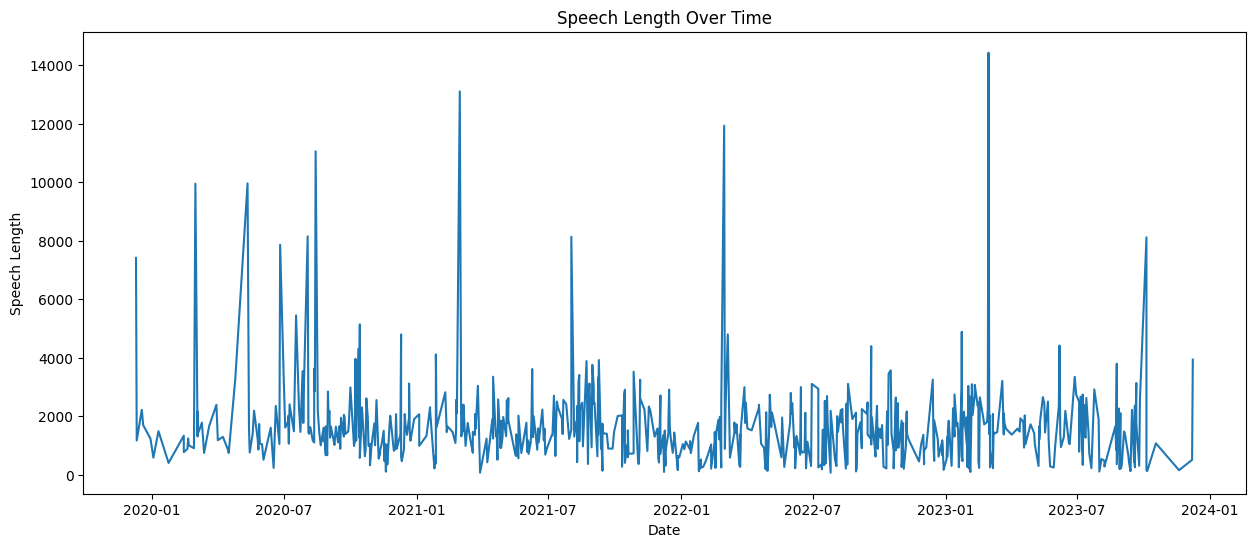

In [17]:
plt.figure(figsize=(15, 6))  # Adjust the width by changing the '15' value

plt.plot(df_af["date"], df_af["speech_length"])
plt.xlabel("Date")
plt.ylabel("Speech Length")
plt.title("Speech Length Over Time")
plt.show()

### Tópicos Principales

Latent Dirichlet Allocation (LDA) es un modelo probabilístico generativo para colecciones discretas de dato como por ejemplo cuerpos de texto.

Es un modelo de jerarquía Bayesiana para modelar automáticamente tópicos extraídos en un corpus. En este modelo, las observaciones (por ejemplo, palabras) son recopiladas en documentos, y la presencia de cada palabra se atribuye cada uno de los temas del documento. Cada documento contendrá reducido de temas.

Link: https://www.andrewng.org/publications/latent-dirichlet-allocation-2/

Gráficamente:

![Colegio Bourbaki](./Images/LDA_graphic.png)

Representación Gráfica del Modelo: 

* **β** siendo la distribución de palabras en cada tópico, 

* **θ** la distribución de tópicos en cada discurso, 

* **M** cuerpo total de texto, 

* **N** discurso, 

* **z** y **w** tópicos y palabras

Analíticamente, ver en Referencias.

Podemos ver el resultado con un ejemplo:

![Colegio Bourbaki](./Images/LDA_example.png)

#### Vectorización de textos

In [18]:
df_af["summary"] = df_af["speech"].apply(preprocesar, package=package)
df_af["summary_length"] = df_af["summary"].str.split().str.len()

In [19]:
df_af.head()

,speech,date,speech_length,summary,summary_length
625,Señora Vicepresidente; Diputadas; Diputados; S...,2019-12-10,7411,señora vicepresidente diputada diputado senado...,3203
564,"Buenas noches, Argentina. Qué linda es esta no...",2019-12-11,1174,noche argentino lindo noche querer lindo noche...,376
644,"Bueno, buenos días, buenas tardes, buen mediod...",2019-12-18,2223,tarde mediodeír gracias invitación momento opo...,760
565,"Parece que hay otro protocolo, pero voy a romp...",2019-12-20,1696,protocolir romper él diputado dejar dormir noc...,551
664,Muchas gracias a todos y a todas. Voy a empeza...,2019-12-30,1233,gracias empezar pedir él disculpa tardé argent...,469


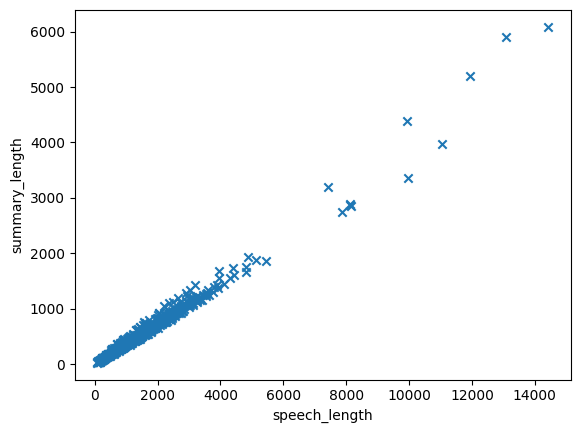

In [20]:
plt.scatter(df_af["speech_length"], df_af["summary_length"], marker="x")
plt.xlabel("speech_length")
plt.ylabel("summary_length")
plt.show()

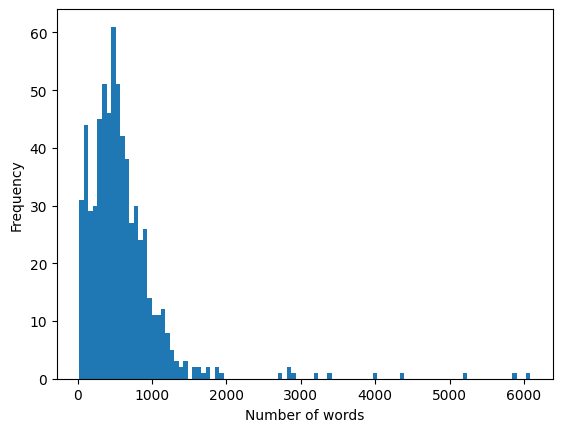

In [21]:
df_af["summary_length"].plot.hist(bins=100)
plt.xlabel("Number of words")
plt.show()

In [22]:
df_af["summary_length"].describe()

count     665.000000
mean      602.440602
std       570.503498
min        23.000000
25%       306.000000
50%       504.000000
75%       755.000000
max      6087.000000
Name: summary_length, dtype: float64

In [23]:
summaries = " ".join(df_af["summary"][i] for i in range(len(df_af)))

print(f"Total words in speech: {len(summaries.split())}")
words_summaries = Counter(summaries.split())
words_summaries.most_common(10)

Total words in speech: 400623


[('argentino', 8326),
 ('él', 5053),
 ('año', 3204),
 ('país', 3196),
 ('decir', 2736),
 ('gracias', 2548),
 ('mundo', 2299),
 ('tiempo', 2180),
 ('trabajar', 2015),
 ('querer', 1980)]

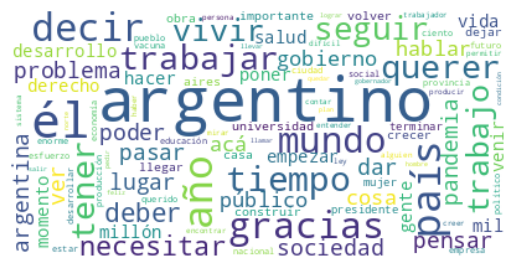

In [24]:
generate_wordcloud(df_af["summary"])

In [25]:
vectorizer = CountVectorizer(min_df = 5, max_df = 0.6, ngram_range=(1,3))

En el CountVectorizer de scikit-learn, min_df y max_df son parámetros que controlan el rango de frecuencia de documentos para los términos (palabras o n-gramas) incluidos en el vocabulario. Aquí te explico qué significa cada parámetro:

* **min_df (frecuencia mínima de documentos):**
        Representa el número mínimo de documentos en los que un término (palabra o n-grama) debe aparecer para ser incluido en el vocabulario.
        Si un término aparece en menos documentos que el valor especificado en min_df, se excluye del vocabulario.
        Este parámetro ayuda a filtrar términos que ocurren con muy poca frecuencia y que podrían considerarse ruido o valores atípicos.

* **max_df (frecuencia máxima de documentos):**
        Representa la proporción máxima de documentos en los que un término puede aparecer para ser incluido en el vocabulario.
        Si un término aparece en más documentos que la proporción especificada en max_df, se excluye del vocabulario.
        Este parámetro ayuda a filtrar términos que son demasiado comunes y que pueden no proporcionar información útil.

In [26]:
BOW = vectorizer.fit_transform(df_af["summary"])
BOW.shape

(665, 14607)

In [27]:
vocabulario = vectorizer.get_feature_names_out()
len(vocabulario)

14607

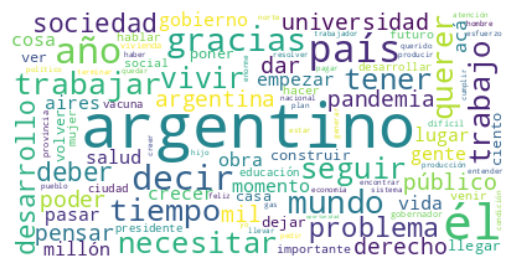

In [28]:
generate_wordcloud(vocabulario)

### Entrenamiento del modelo

El número óptimo de topicos depende de las caracteristicas del texto a analizar (el largo de los textos, la cantidad de distintas ideas)

No obstante existen algunas metricas que ayudan a determinar k.

In [29]:
k = 4

In [30]:
lda_model = LatentDirichletAllocation(
    n_components=k,  # número de tópicos (típico: 5–20)
    learning_method="batch",  # "batch" o "online"
    max_iter=50,  # número de iteraciones (10–50 suele bastar)
    random_state=42,  # semilla para reproducibilidad
    learning_decay=0.7,  # solo para "online": entre 0.5 y 0.9
    learning_offset=10.0,  # solo para "online": >= 10
    doc_topic_prior=None,  # α: prior de distribución documento–tópico
    topic_word_prior=None,  # β: prior de distribución tópico–palabra
)

In [31]:
%%time
lda_model.fit(BOW)  # entrena el modelo y obtiene la matriz documento-topico

CPU times: user 50.5 s, sys: 2min 46s, total: 3min 37s
Wall time: 30.4 s


,n_components,4
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,50
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


### Distribución de temas en cada discurso  ($\theta$)

In [32]:
doc_top = pd.DataFrame(lda_model.transform(BOW))
print(doc_top.shape)
doc_top.head()

(665, 4)


,0,1,2,3
0,0.151018,0.481054,0.367841,0.000088
1,0.031610,0.153160,0.169082,0.646149
2,0.085251,0.614665,0.000363,0.299721
3,0.054844,0.317770,0.000555,0.626831
4,0.000723,0.000713,0.000739,0.997825


In [33]:
doc_top.sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
660    1.0
661    1.0
662    1.0
663    1.0
664    1.0
Length: 665, dtype: float64

In [34]:
df_lda = pd.merge(df_af, doc_top, left_index=True, right_index=True)
df_lda.head()

,speech,date,speech_length,summary,summary_length,0,1,2,3
625,Señora Vicepresidente; Diputadas; Diputados; S...,2019-12-10,7411,señora vicepresidente diputada diputado senado...,3203,0.104997,0.604797,0.000250,0.289957
564,"Buenas noches, Argentina. Qué linda es esta no...",2019-12-11,1174,noche argentino lindo noche querer lindo noche...,376,0.002692,0.002709,0.002696,0.991902
644,"Bueno, buenos días, buenas tardes, buen mediod...",2019-12-18,2223,tarde mediodeír gracias invitación momento opo...,760,0.000489,0.000506,0.000476,0.998529
565,"Parece que hay otro protocolo, pero voy a romp...",2019-12-20,1696,protocolir romper él diputado dejar dormir noc...,551,0.000508,0.397646,0.179692,0.422154
664,Muchas gracias a todos y a todas. Voy a empeza...,2019-12-30,1233,gracias empezar pedir él disculpa tardé argent...,469,0.132522,0.500700,0.123855,0.242923


### Distribución de palabras en cada tópico ($\mu$)

In [35]:
μs = pd.DataFrame(lda_model.exp_dirichlet_component_, columns=vocabulario)
print(μs.shape)
μs

(4, 14607)


,abajo,abandonado,abandonado suerte,abandonar,abandono,abarcar,abastecer,abastecimiento,abdo,abierto,...,único pensar,único preocupación,único preocupar,único privilegiado,único quedar,único querer,único sociedad,único tener,único único,útil
0,1.816594e-04,1.901323e-04,2.516073e-07,1.169981e-04,2.687954e-05,5.639275e-05,2.212348e-07,2.306294e-07,2.090347e-07,0.000370,...,2.246006e-07,3.495574e-05,2.470554e-07,2.315310e-07,2.182723e-07,2.611661e-07,2.069603e-07,1.340974e-05,6.469701e-05,7.402866e-05
1,6.813601e-05,5.308065e-05,1.657628e-07,2.593310e-07,2.068230e-07,4.249391e-07,6.213348e-05,9.611327e-05,9.891957e-05,0.000246,...,1.690911e-07,1.570126e-07,1.402646e-07,1.822464e-07,1.592865e-07,6.825108e-07,1.927772e-07,7.919607e-06,1.581811e-07,6.264924e-05
2,3.186884e-07,2.820025e-07,2.795008e-05,7.369462e-05,4.716962e-05,5.158666e-07,3.761129e-07,1.837730e-05,2.811259e-07,0.000149,...,2.414084e-07,2.575176e-07,2.380125e-07,1.488111e-05,3.214259e-07,1.812923e-06,2.390650e-05,2.877420e-07,3.225286e-07,2.538163e-07
3,1.750270e-04,3.553830e-04,1.525469e-05,1.552478e-04,7.350123e-05,7.751254e-06,8.025359e-08,8.449049e-08,1.473357e-07,0.000050,...,3.131938e-05,6.573230e-05,3.680764e-05,3.606538e-05,2.580142e-05,5.671009e-05,1.663627e-05,1.384528e-05,5.416957e-05,1.788292e-05



Palabras más frecuentes del topico 0
['salud', 'aires', 'vacuna', 'problema', 'pandemia', 'provincia', 'sistema', 'virus', 'caso', 'contagio']


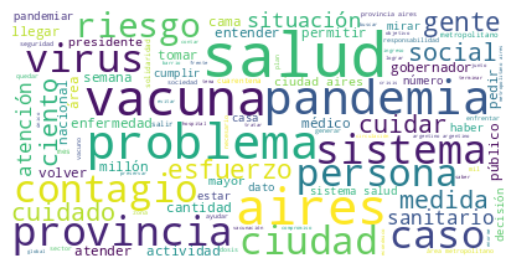


Palabras más frecuentes del topico 1
['desarrollo', 'producción', 'empresa', 'producir', 'millón', 'economía', 'crecer', 'gas', 'problema', 'desarrollar']


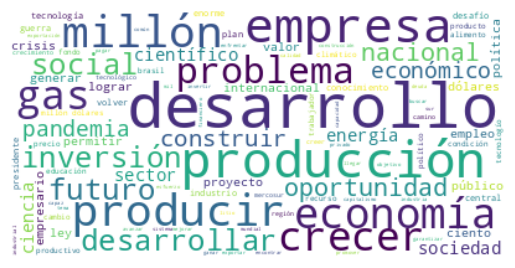


Palabras más frecuentes del topico 2
['derecho', 'mujer', 'fuerza', 'presidente', 'justicia', 'pueblo', 'democracia', 'hombre', 'sociedad', 'ley']


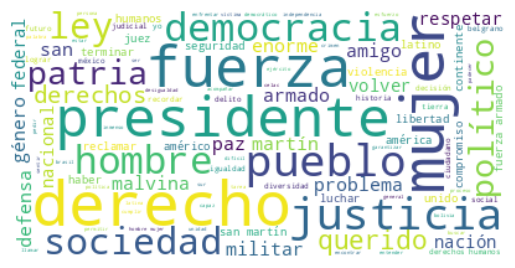


Palabras más frecuentes del topico 3
['universidad', 'obra', 'casa', 'público', 'gente', 'mil', 'llegar', 'sociedad', 'derecho', 'construir']


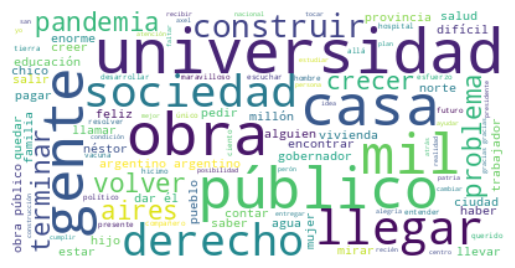

In [36]:
for top in range(k):
    print(f"\nPalabras más frecuentes del topico {top}")
    words = list(μs.T[top].sort_values(ascending=False).head(10).index)
    freq = μs.T[top].sort_values(ascending=False).head(100)
    print(words)
    wordcloud = WordCloud(
        max_font_size=50,
        max_words=100,
        background_color="white",
        normalize_plurals=False,
        collocations=False,
    ).generate_from_frequencies(freq)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Visualización del modelo

In [37]:
pyLDAvis.lda_model.prepare(lda_model, BOW, vectorizer)

/home/pdconte/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4120209) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/pdconte/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4120209) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/pdconte/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4120209) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/pdconte/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4120209) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/pdconte/.local/lib/python3.12/site-packages/joblib/externals/loky/back

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.010925 -0.055300       1        1  43.914016
1     -0.063014  0.162072       2        1  25.597470
0     -0.100439 -0.102714       3        1  16.287981
2      0.174377 -0.004058       4        1  14.200532, topic_info=             Term         Freq        Total Category  logprob  loglift
12001       salud  1072.000000  1072.000000  Default  30.0000  30.0000
8647        mujer   860.000000   860.000000  Default  29.0000  29.0000
3910      derecho  1188.000000  1188.000000  Default  28.0000  28.0000
4050   desarrollo  1212.000000  1212.000000  Default  27.0000  27.0000
389         aires  1013.000000  1013.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
12220   seguridad   121.630474   261.900945   Topic4  -6.1681   1.1849
10685    problema   151.668842  1498.572137   Topic4  -5.9473  -0.3387
4977       enorme   134.361316   772.901739   Topic4  -6.0685   0.2023
14198      volver   129.410252  1046.970080   Topic4  -6.1061  -0.1388
8844     nacional   127.263498   829.532437   Topic4  -6.1228   0.0773

[357 rows x 6 columns], token_table=       Topic      Freq                      Term
term                                            
183        1  0.991664                 acueducto
362        1  0.862717                      agua
362        2  0.124147                      agua
362        4  0.010521                      agua
389        1  0.571131                     aires
...      ...       ...                       ...
14323      4  0.070971                      área
14324      1  0.117141        área metropolitano
14324      3  0.878560        área metropolitano
14326      1  0.103180  área metropolitano aires
14326      3  0.894223  área metropolitano aires

[728 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

Si les interesa guardar el modelo:

In [38]:
# import pickle
# path = ''
# tuple_models = (lda_model, BOW, vectorizer)
# pickle.dump(tuple_models, open (path + "model.pkl", 'wb'))

In [39]:
# import pickle
# path = ''
# lda_model, BOW, vectorizer = pickle.load(open(path + "tuple_model_books_k10.pkl", 'rb'))

### Libreria Gensim

Veamos cómo podemos realizar lo mismo con la librería Gensim: en scikit-learn, el proceso para implementar el modelado de temas mediante la Asignación de Dirichlet Latente (LDA) es ligeramente diferente al de Gensim

In [40]:
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
import gensim.corpora as corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis 
from gensim.models.coherencemodel import CoherenceModel

En Gensim, la configuración de filtros y ajustes similares a los utilizados en el CountVectorizer de scikit-learn para manejar umbrales de frecuencia de documentos (min_df y max_df) y rangos de n-gramas no está disponible directamente a través de una clase o método único. Sin embargo, se puede lograr una funcionalidad similar mediante el preprocesamiento personalizado y el uso de las capacidades incorporadas de Gensim. A continuación vemos cómo implementar manualmente estas funciones:

* Preprocesamiento para implementar min_df y max_df:
Podemos filtrar los tokens que aparecen con demasiada o poca frecuencia en el corpus directamente a través de la clase Diccionario de Gensim.

* Manejo de N-gramas:
Gensim no admite n-gramas de forma nativa en su proceso de diccionario, por lo que tendríamos que crear los n-gramas manualmente antes de la creación del diccionario.

In [41]:
def create_ngrams(texts, ngram_range=(1, 3)):
    # Tokenize the documents.
    tokenized_texts = [simple_preprocess(doc, deacc=True) for doc in texts]

    # Build n-grams models (bigrams, trigrams, etc.)
    ngrams = tokenized_texts
    for n in range(2, ngram_range[1] + 1):
        phrases = Phrases(ngrams, min_count=1, threshold=1)
        phraser = Phraser(phrases)
        ngrams = [phraser[doc] for doc in ngrams]

    return ngrams


In [42]:
def filtering_extremes(texts, no_below=30, no_above=0.5):
    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    dictionary.filter_n_most_frequent(100)
    corpus = [dictionary.doc2bow(text) for text in texts]
    return dictionary, corpus

In [43]:
# Create a dictionary and corpus needed for Topic Modeling
documents = [word for word in df_af['summary']]
ngram_texts = create_ngrams(documents, ngram_range=(1, 3))
dictionary, corpus = filtering_extremes(ngram_texts)

In [44]:
%%time
lda_model_gensim = LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, random_state=42)

CPU times: user 802 ms, sys: 277 µs, total: 802 ms
Wall time: 804 ms


*Noten que el ajuste del modelo tarda mucho menos!*

In [45]:
# View the topics in the model
for idx, topic in lda_model_gensim.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}')

Topic: 0 
Words: 0.004*"politica" + 0.004*"vacuna" + 0.004*"publico" + 0.004*"universidad" + 0.004*"generar" + 0.004*"obra" + 0.004*"tierra" + 0.004*"tema" + 0.003*"gobernador" + 0.003*"proyecto"
Topic: 1 
Words: 0.004*"economia" + 0.004*"virus" + 0.004*"axel" + 0.003*"objetivo" + 0.003*"situacion" + 0.003*"frente" + 0.003*"ciudad" + 0.003*"vacuna" + 0.003*"plan" + 0.003*"ley"
Topic: 2 
Words: 0.004*"construccion" + 0.004*"nestor" + 0.004*"tema" + 0.003*"justicia" + 0.003*"seguro" + 0.003*"agua" + 0.003*"existir" + 0.003*"democracia" + 0.003*"resultado" + 0.003*"valor"
Topic: 3 
Words: 0.005*"mujer" + 0.004*"trabajador" + 0.004*"obra" + 0.004*"universidad" + 0.003*"significar" + 0.003*"plan" + 0.003*"democracia" + 0.003*"escuchar" + 0.003*"politica" + 0.003*"ley"


In [46]:
vis = gensimvis.prepare(lda_model_gensim, corpus, dictionary)
pyLDAvis.display(vis)

Para evaluar los modelos de Asignación de Dirichlet Latente (LDA), que se utilizan habitualmente en el modelado de temas, puede utilizar varias métricas para evaluar la calidad y eficacia del modelo. Estas métricas pueden clasificarse a grandes rasgos en medidas de coherencia y perplejidad:

* Perplejidad: Se trata de una medida estadística de lo bien que un modelo probabilístico predice una muestra. Una puntuación de perplejidad más baja indica que el modelo predice mejor la muestra. Se calcula examinando la probabilidad de los datos de prueba dado el modelo entrenado. Sin embargo, una menor perplejidad no siempre significa que el modelo tenga más sentido, ya que puede no correlacionarse bien con el juicio humano sobre la coherencia temática.

* Coherencia temática: Las medidas de coherencia evalúan el grado en que las palabras principales de cada tema tienen sentido juntas como un grupo cohesionado. Las puntuaciones de coherencia más altas suelen indicar temas más interpretables. Las medidas de coherencia más utilizadas son:
1) C_v (Coherencia V-medida): Utiliza una ventana deslizante, una segmentación de un conjunto de las palabras más importantes y una medida de confirmación basada en la información mutua puntual normalizada (NPMI) y la similitud del coseno.
2) U_mass: Basada en el recuento de co-ocurrencias de documentos, una medida de la cantidad de co-ocurrencias de las palabras principales de un tema en los mismos documentos, que se calcula sin utilizar recursos externos.
3) C_uci y C_npmi: se basan en las probabilidades de co-ocurrencia de palabras, a menudo utilizando un enfoque de ventana deslizante en un gran corpus externo.
4) C_umass: Es otra medida de coherencia basada en la co-ocurrencia de documentos.

* Diversidad de temas: Mide lo diferentes que son los temas entre sí. Idealmente, un buen modelo LDA producirá temas diversos, indicando un solapamiento mínimo en los términos que componen cada tema.

* Juicio humano: A menudo, se utilizan revisiones cualitativas de anotadores humanos para evaluar el significado y la coherencia de los temas generados por LDA. Los anotadores suelen evaluar si las palabras principales de un tema parecen estar relacionadas y si los temas parecen distintos e interpretables.

#### Métricas en Gensim

Gensim nos permite computar la Coherencia del modelo:

In [47]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_gensim, texts=ngram_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)

/opt/python/3.12.11/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=4120209) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/python/3.12.11/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=4120209) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/python/3.12.11/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=4120209) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/python/3.12.11/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=4120209) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/python/3.12.11/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=4120209) is multi-threaded, use of fork() may lead to deadloc


Coherence Score: 0.21348560439460457


Podemos crear una función para calcular la diversidad de los tópicos:

In [48]:
def topic_diversity(lda_model, topn=10):
    unique_words = set()
    total_words = topn * lda_model.num_topics
    for topic_id in range(lda_model.num_topics):
        top_words = [word for word, _ in lda_model.get_topic_terms(topic_id, topn=topn)]
        unique_words.update(top_words)
    diversity_score = len(unique_words) / total_words
    return diversity_score

In [49]:
# Calculate Topic Diversity
diversity_score = topic_diversity(lda_model_gensim)
print('Topic Diversity:', diversity_score)

Topic Diversity: 0.8


Podemos calcular también la perplejidad:

In [50]:
import numpy as np

# Calculate the perplexity
log_perplexity = lda_model_gensim.log_perplexity(corpus)
print("Log Perplexity: ", log_perplexity)

# You can convert log perplexity to perplexity if needed
perplexity = np.exp(-log_perplexity)
print("Perplexity: ", perplexity)

Log Perplexity:  -6.810552146835381
Perplexity:  907.371671056269


Interpretación de las puntuaciones

* Puntuación de coherencia: Mide hasta qué punto las palabras principales de cada tema contribuyen a crear un tema coherente. Una puntuación de coherencia cercana a 0,155 sugiere que los temas generados por su modelo pueden no ser muy interpretables o significativos. Normalmente, se desea una puntuación de coherencia más alta (cercana a 1,0), ya que indica que las palabras de cada tema están más relacionadas semánticamente.

* Diversidad de temas: Una puntuación de diversidad de 0,825 significa que aproximadamente el 82,5% de las palabras principales de todos los temas son únicas. Esto sugiere una diversidad alta; una puntuación baja indicaría mas solapamiento entre los temas y un contenido temático menos diferenciado.

* Perplejidad: La perplejidad es una medida de lo bien que una distribución de probabilidad o un modelo de probabilidad predice una muestra. En el contexto de LDA: Una menor perplejidad indica típicamente un mejor modelo. El valor de perplejidad de aproximadamente 1053 sugiere que puede haber margen de mejora, ya que los valores más bajos suelen ser mejores. Sin embargo, la escala de perplejidad puede variar mucho en función del tamaño del corpus y del vocabulario, por lo que también es importante compararlo con líneas de base u otros modelos entrenados con datos similares.

Mejorar el modelo en Gensim

Para mejorar tanto la coherencia como la diversidad, considere las siguientes estrategias:

1. Optimizar el preprocesamiento:

    Perfeccionamiento de las palabras de exclusión: Mejore su lista de palabras de exclusión para incluir más términos específicos del contexto que puedan estar desordenando sus temas.
    Ajuste de la tokenización: Asegúrese de que la tokenización capta los términos relevantes y considere la posibilidad de realizar ajustes como el stemming o la lematización.

2. Experimentar con hiperparámetros:

    * Número de temas: Ajuste el número de temas. A veces, un número mayor o menor puede influir drásticamente en la calidad y la interpretabilidad de los resultados.
    * Parámetros Alfa y Beta: Son los hiperparámetros Dirichlet que controlan la dispersión de temas. Experimentar con ellos puede ayudar a encontrar un conjunto de temas más coherente.
    * Iteración y pasadas: Aumentar el número de pasadas e iteraciones sobre el corpus puede conducir a modelos temáticos más estables, ya que el algoritmo tiene más oportunidades de aprender los datos.

3. Mejora del manejo de N-gramas:

    * Ampliar el rango de N-gramas: Si aún no se ha maximizado, considere la posibilidad de aumentar el rango de n-gramas para capturar más contextos basados en frases que puedan sacar a la luz temas más coherentes.
    * Filtros de frecuencia: Ajuste los filtros min_df y max_df para optimizar la inclusión de n-gramas en función de cómo aparecen en los documentos.

Ejercicios:

1) Conceptos Básicos:
* ¿Cómo describirías en términos generales qué es el Modelado de Asociación Latente (LDA)?
        
* Explique el concepto de "temas" en el contexto de LDA.
        
* ¿Cuál es el objetivo principal de LDA en el procesamiento de lenguaje natural?

2) Proceso de LDA:
* Describe los pasos fundamentales en el proceso de aplicar LDA a un conjunto de documentos.
        
* ¿Qué representa la distribución de tópicos en un documento según LDA?

3) Parámetros y Ajuste:
* ¿Qué papel juegan los parámetros alpha y beta en el modelo LDA?
        
* ¿Cómo afecta el número de tópicos elegido al resultado del modelado LDA?

4) Aplicaciones Prácticas:
* Proporciona ejemplos de situaciones del mundo real donde el modelado LDA podría ser útil.
        
* ¿Cómo podría LDA ser utilizado para descubrir patrones en grandes conjuntos de documentos?

5) Desafíos y Limitaciones:
* ¿Cuáles son algunos desafíos comunes al aplicar LDA en el procesamiento de lenguaje natural?
        
* ¿Puedes mencionar algunas limitaciones de LDA y cómo podrían abordarse?

6) Comparación con Otros Modelos:
* ¿Cómo se compara LDA con otros enfoques de modelado de tópicos en el procesamiento de lenguaje natural? (Si es que conocen alguno)

7) **Como vimos usamos BoW para vectorizar el texto, podriamos usar TD-IDF? Explique. Obtendríamos mejores agrupaciones?**

8) **Evaluar el modelo con múltiples ejecuciones:** LDA utiliza una inicialización aleatoria para los parámetros del modelo. Esto significa que, incluso con la misma configuración y datos, los resultados pueden variar debido a diferentes semillas aleatorias. Si la variabilidad sigue siendo un problema, se podría realizar múltiples ejecuciones del modelo y promediar o analizar los resultados para obtener una visión más estable.

9) **Mejorar el modelo de Gensim!** Entender las diferencias de implementación entre ambas librerías

![Colegio Bourbaki](./Images/Matematicas.png)

![Colegio Bourbaki](./Images/Contacto.png)